# Seq2seq: Machine translation with pytorch and torchtext

In [1]:
!pip install torchinfo

In [2]:
!pip install -U torchtext==0.9.0

     |████████████████████████████████| 7.1 MB 4.6 MB/s 
     |████████████████████████████████| 735.5 MB 15 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0
    Uninstalling torch-1.9.0:
      Successfully uninstalled torch-1.9.0
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.8.0
    Uninstalling torchtext-0.8.0:
      Successfully uninstalled torchtext-0.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.8.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.8.0 which is incompatible.


In [3]:
##############################################
#  COMPLETE CODE BELOW WHERE YOU SEE # ...   #
##############################################


import torch # torch==1.8.0
import torch.nn.functional as F
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader, TensorDataset 
from tqdm.notebook import tqdm
import torch.optim as optim

from torchtext.legacy.datasets import Multi30k # torchtext==0.8
from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import time

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

This notebook trains  seq2seq models for German to English translation, using PyTorch and torchtext. Yet, this kind of models can be applied on any problem that requires going from one sequence to another, e.g., text summarization and visual question answering (VQA).

The encoder-decoder architecture represents one of the most common used baseline for seq2seq models. This architecture commonly use a RNN to encode the input sentence into a single vector, namely <em>context vector</em> (the final hidden state of the encoder). This vector is then decode by a second RNN, which will be learned to generate the output sentence (one word at a time).

The models that we are implementing here are from the [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/pdf/1409.3215.pdf) paper.

## Preparing Data
`pytorchtext` will be used to help us do all the reuired data preprocessing. We'll also use `spacy` to assist in the tokenization of the data.\
A tokenizer is used to turn a string containing a sentence into a list of individual tokens, e.g., "guten morgen !" --> ["guten", "morgen", "!"].

spaCy has model for each language ("de_core_news_sm" for German and "en_core_web_sm" for English) which need to be loaded so we can access the tokenizer of each model.

<strong>Note:</strong> the models must first be downloaded using the following on the command line:

In [5]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     |████████████████████████████████| 12.0 MB 5.5 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 14.9 MB 5.7 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')


We can now load the models via spacy.load('de_core_news_sm')


In [6]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [7]:
def tokenize_de(text):
    
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    # i.e., the authors of the reference paper find it beneficial to reverse the
    #order of the input which they believe "introduces many short term dependencies
    #in the data that make the optimization problem much easier".
    
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    # ... tokenize the English sentence here
    return [tok.text for tok in spacy_en.tokenizer(text)]
    

torchtext's `Field` handles how data should be processed:

In [8]:
SRC = Field(tokenize = tokenize_de, #the tokenize argument to the correct tokenization function for each,
            init_token = '<sos>',   #The field also appends the "start of sequence" '<sos>'
            eos_token = '<eos>',   #and "end of sequence" '<eos>'
            lower = True)


# ... define the target Field here
TRG = Field(tokenize = tokenize_en, #the tokenize argument to the correct tokenization function for each,
            init_token = '<sos>',   #The field also appends the "start of sequence" '<sos>'
            eos_token = '<eos>',   #and "end of sequence" '<eos>'
            lower = True)

Now let's download the train, val and test data.
The used dataset in this work is the [Multi30k](https://github.com/multi30k/dataset). This dataset contains ~30k parallel English, German and French 12-word sentences.

In [9]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 670kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 230kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 224kB/s]


In [10]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [11]:
# ...  print an example and make sure that the source sentence is reversed
print(vars(train_data.examples[0]))

{'src': ['.', 'büsche', 'vieler', 'nähe', 'der', 'in', 'freien', 'im', 'sind', 'männer', 'weiße', 'junge', 'zwei'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


Next, we'll build the <em>vocabulary</em> for the source and target languages. The <em>vocabulary</em> is used to associate each unique token with an index.

In [12]:
SRC.build_vocab(train_data, min_freq = 2)

#min_freq argument only allows tokens that appear at least 2 times to be in our vocab


# ... build the target vocab here
TRG.build_vocab(train_data, min_freq = 2)


In [13]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7855
Unique tokens in target (en) vocabulary: 5893


The final step of preparing the data is to create the iterators. These can be iterated on to return a batch of data which will have a `src` attribute and a `trg` attribute.

When we get a batch of examples using an iterator we need to make sure that all of the source sentences are padded to the same length, the same with the target sentences. Luckily, torchText iterators handle this for us!

In [14]:
#BucketIterator instead of the standard Iterator as it creates batches in such a way
#that it minimizes the amount of padding in both the source and target sentences.

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

## Building the Seq2Seq Model

We build the model in 3 parts: The encoder, the decoder and a seq2seq model that\
encapsulates the encoder and decoder and will provide a way to interface with each.


### Encoder


The Encoder is a 2-layer LSTM (the ref. paper uses a 4-layer LSTM but for the sake of simplicity, i.e., training time, we'll only use 2 layers).\
So our encoder looks like this:

<img src="assets/encoder.png" align="left"/>

In [15]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout) #  PS: This time batch_first = False (by default)
                                                                          # because the torchtext data are in that
                                                                          # order (seq, batch, feature).
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        embedded = self.dropout(self.embedding(src))    
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

### Decoder

Next, we'll build our decoder, which will also be a 2-layer LSTM.

<img src="assets/decoder.png" align="left"/>

In [16]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        # ... complete the implementation of the decoder model here        
        # used for asseration later on
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.emb_dim = emb_dim
        self.output_dim = output_dim

        self.dropout = nn.Dropout(dropout)

        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        
        
        
        
        
        
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

### Seq2Seq

For the final part of the implemenetation, we'll build the seq2seq model. This will handle:

* receiving the input/source sentence
* using the encoder to produce the context vectors
* using the decoder to produce the predicted output/target sentence

Our full model will look like this:


<img src="assets/seq2seq.png" align="left"/>

In [17]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        assert encoder.hid_dim == decoder.hid_dim, "Hidden dimensions of encoder and decoder must be equal!" # ...
        assert encoder.n_layers == decoder.n_layers, "Encoder and decoder must have equal number of layers!" # ...
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time

        trg_len, batch_size = trg.size()
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(src.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

## Training the Seq2Seq Model

Now let's train our implemented model. 

First, we'll initialize our model. As mentioned before, the input and output dimensions are defined by the size of the vocabulary. The embedding\
dimesions and dropout for the encoder and decoder can be different, but the number of layers and the size of the hidden/cell states must be the same. 

We then define the encoder, decoder and then our Seq2Seq model.

In [18]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec) # ... the seq2seq model goes here
model = model.to(device)

Next up is initializing the weights of our model. The authots of the ref. paper have initialized all weights from a uniform distribution between -0.08 and +0.08.

We initialize weights in PyTorch by creating a function which we `apply` to our model. When using `apply`, the `init_weights` function will be called on every module and sub-module within our model. For each module we loop through all of the parameters and sample them from a uniform distribution with `nn.init.uniform_`.

In [19]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7855, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=5893, bias=True)
  )
)

Next we define our optimizer and loss function. Our loss function calculates the average loss per token, however by passing the index of the `<pad>` token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token.

In [20]:
optimizer = optim.Adam(model.parameters())

TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Next, we'll define our training loop.

In [21]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(tqdm(iterator)):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].flatten()
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.\
We must remember to set the model to evaluation mode with model.eval(). This will turn off dropout (and batch normalization, if used).\
We use the new `with torch.no_grad()` context manager to ensure no gradients are calculated within the block. This reduces memory consumption and speeds things up.

In [22]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].flatten()

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

We can finally start training our model!

At each epoch, we'll be checking if our model has achieved the best validation loss so far. If it has, we'll update our best validation loss and save the parameters of our model (called `state_dict` in PyTorch). Then, when we come to test our model, we'll use the saved parameters used to achieve the best validation loss. 

We'll be printing out both the loss and the perplexity at each epoch. It is easier to see a change in perplexity than a change in loss as the numbers are much bigger.

In [30]:
N_EPOCHS = 10
CLIP = 1
train_losses = []
val_losses = []

best_valid_loss = float('inf')

start = time.time()
for epoch in range(N_EPOCHS):
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'seq2seq-model.pt')

    # ... print the epoch number and the time it takes here, e.g., Epoch: 08 | Time: 0m 27s
    print(f'Epoch {epoch}\t-\tTime:{time.strftime("%H:%M:%S", time.gmtime(time.time()-start))}')


    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    train_losses.append(train_loss)
    val_losses.append(valid_loss)

  0%|          | 0/227 [00:00<?, ?it/s]

Epoch 0	-	Time:00:01:14
	Train Loss: 2.898 | Train PPL:  18.141
	 Val. Loss: 3.880 |  Val. PPL:  48.412


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch 1	-	Time:00:02:29
	Train Loss: 2.808 | Train PPL:  16.572
	 Val. Loss: 3.800 |  Val. PPL:  44.695


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch 2	-	Time:00:03:44
	Train Loss: 2.724 | Train PPL:  15.245
	 Val. Loss: 3.741 |  Val. PPL:  42.139


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch 3	-	Time:00:04:59
	Train Loss: 2.624 | Train PPL:  13.787
	 Val. Loss: 3.703 |  Val. PPL:  40.556


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch 4	-	Time:00:06:14
	Train Loss: 2.540 | Train PPL:  12.684
	 Val. Loss: 3.708 |  Val. PPL:  40.781


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch 5	-	Time:00:07:28
	Train Loss: 2.493 | Train PPL:  12.102
	 Val. Loss: 3.644 |  Val. PPL:  38.246


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch 6	-	Time:00:08:43
	Train Loss: 2.409 | Train PPL:  11.127
	 Val. Loss: 3.670 |  Val. PPL:  39.257


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch 7	-	Time:00:09:57
	Train Loss: 2.337 | Train PPL:  10.351
	 Val. Loss: 3.691 |  Val. PPL:  40.104


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch 8	-	Time:00:11:12
	Train Loss: 2.279 | Train PPL:   9.770
	 Val. Loss: 3.626 |  Val. PPL:  37.565


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch 9	-	Time:00:12:27
	Train Loss: 2.219 | Train PPL:   9.196
	 Val. Loss: 3.685 |  Val. PPL:  39.845


We'll load the parameters (`state_dict`) that gave our model the best validation loss and run it the model on the test set.

In [31]:
model.load_state_dict(torch.load('seq2seq-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.575 | Test PPL:  35.703 |


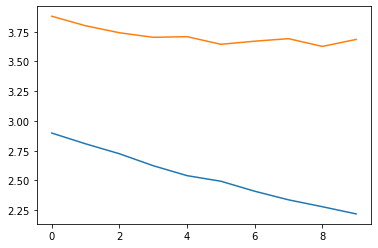

In [32]:
# ... plot the training and test loss here (optional)
plt.plot(train_losses)
plt.plot(val_losses)

In [33]:
def translate_sentence(model, sentence, german, english, device, max_length=50):

    tokens = tokenize_de(sentence)[::-1]
    tokens.insert(0, german.init_token)
    tokens.append(german.eos_token)
    print(tokens)


    text_to_indices = [german.vocab.stoi[token] for token in tokens]
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    # Build encoder hidden, cell state
    with torch.no_grad():
        hidden, cell = model.encoder(sentence_tensor)

    outputs = [english.vocab.stoi["<sos>"]]

    for _ in range(max_length):
        previous_word = torch.LongTensor([outputs[-1]]).to(device)

        with torch.no_grad():
            output, hidden, cell = model.decoder(previous_word, hidden, cell)
            best_guess = output.argmax(1).item()

        outputs.append(best_guess)

        # Model predicts it's the end of the sentence
        if output.argmax(1).item() == english.vocab.stoi["<eos>"]:
            break

    translated_sentence = [english.vocab.itos[idx] for idx in outputs]
    return translated_sentence[1:]

In [34]:
# ... print a GE->EN output example here
model.eval()
translated_sentence = translate_sentence(model, "Ein blaues Hemd", SRC, TRG, device, max_length=50)
print(translated_sentence)

['<sos>', 'Ein', 'blaues', 'Hemd', '<eos>']
['blue', 'and', 'white', '.', '<eos>']


In [35]:
model.eval()
translated_sentence = translate_sentence(model, "Ein Busch ist grün.", SRC, TRG, device, max_length=50)
print(translated_sentence)

['<sos>', 'Ein', 'Busch', 'ist', 'grün', '.', '<eos>']
['wearing', 'blue', 'and', 'white', '.', '<eos>']


In [36]:
model.eval()
translated_sentence = translate_sentence(model, "Ich bin glücklich.", SRC, TRG, device, max_length=50)
print(translated_sentence)

['<sos>', 'Ich', 'bin', 'glücklich', '.', '<eos>']
['styled', 'counter', 'trying', 'to', 'bake', '.', '<eos>']
